# Финальный проект специализации "Машинное обучение и анализ данных"
## Идентификация интернет-пользователей
*Алексей Галак*

### Цели и задачи проекта

В рамках проекта решается задача идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

Мы будем решать похожую задачу. Есть некоторый определенный, выделенный пользователь (назовем его Alice). По последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком (сессии), мы будем определять, Alice это или кто-то другой (взломщик).

Для этой задачи есть [соревнование](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) на Kaggle, на которое мы и будем опираться при итоговой оценке качества модели и для сравнения результатов с другими участниками соревнования.

Мы будем строить вероятностную модель бинарной классификации, которая для каждой сессии будет вычислять вероятность того, что эта сессия принадлежит Alice. Соответственно, чем ближе эта вероятность к 1, тем больше уверенность модели в том, что эта сессия принадлежит Alice, а чем она ближе к 0, тем больше уверенность в том, что сессия принадлежит не Alice.

### Описание данных

Обучающая выборка приведена в файле `train_sessions.csv`,  тестовая (без целевого признака) - в файле `test_sessions.csv`.

Данные представлены в виде сессий - последовательностей сайтов, посещенных одним человеком. Каждый посещенный сайт представлен идентификатором и временем посещения. Длина сессии ограничена 10 сайтами, но может быть и меньше (в этом случае соответствующие сайту признаки отсутствуют). Сопоставление сайтов (доменных имен) и их идентификаторов приведено в pickle-файле со словарем `site_dic.pkl`.
* Признаки `site_i`, i=1..10 – идентификаторы посещенных сайтов
* Признаки `time_i`, i=1..10 – время посещения сайтов `site_i`
* Целевой признак `target` – индикатор того, что сессия принадлежит Alice (1 - Alice, 0 - кто-то другой)

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import csr_matrix, csc_matrix, hstack as shstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, learning_curve
from sklearn.metrics import roc_auc_score
from boruta import BorutaPy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PATH_TO_DATA = '../data/raw'
PATH_TO_SUBMISSIONS = '../kaggle_submissions'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [5]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


### Методика измерения качества

Модель оценивается на основании предлагаемой в соревновании метрики ROC-AUC - площади под ROC-кривой. Чем выше показатель ROC-AUC, тем качественнее классификатор, при этом значение 0.5 демонстрирует непригодность выбранного метода классификации (соответствует случайному угадыванию либо константному предсказанию).

### Предобработка данных и создание признаков

На основе исходных данных создадим признаки - количества вхождений сайта в сессию, по одному для каждого сайта. Получается большая разреженная матрица.

Кроме того, создадим новые признаки:
* `start_hour` - час начала сессии (0-23)
* `time_of_day` - время суток. 0 - ночь (0:00-5:00), 1 - утро (6:00-11:00), 2 - день (12:00-17:00), 3 - вечер (18:00-23:00)
* `day_of_week` - день недели, от 0 (понедельник) до 6 (воскресенье)
* `weekend` - индикатор выходных

Все эти признаки - категориальные, поэтому перед обучением модели закодируем их с помощью one-hot encoding.

In [6]:
train_test_df = pd.concat([train_df, test_df], sort=False)
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
train_test_df_times = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(np.datetime64('NaT')).astype(np.datetime64)
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


In [7]:
def sparsify_data(X, verbose=False):
    data = []
    row_ind = []
    col_ind = []
    max_site_ID = 0
    #split user site IDs into sessions and construct a sparse matrix of ID counts in a session
    for row_idx, row in enumerate(X.values):
        for site_ID in row:
            if site_ID > max_site_ID:
                max_site_ID = site_ID
            row_ind.append(row_idx)
            col_ind.append(site_ID) #site IDs can also serve as column indices, because they range from 0 to something
            data.append(1)
    X_sparse = csr_matrix((data, (row_ind, col_ind)), shape=(X.shape[0], max_site_ID+1), dtype=np.int64)
    return X_sparse[:, 1:] #exclude site ID 0

In [8]:
def prepare_features(X_features, feature_types):
    empty_array = np.array([]).reshape(X_features.shape[0], 0)
    
    prepared_features = empty_array
    if len(feature_types['prepared']) > 0:
        prepared_features = X_features[feature_types['prepared']].values
    
    encoded_features = empty_array
    if len(feature_types['categorical']) > 0:
        features_to_encode = X_features[feature_types['categorical']].values
        encoded_features = OneHotEncoder(sparse=True, dtype=np.int16).fit_transform(features_to_encode)
    
    log_features = empty_array
    if len(feature_types['to_log']) > 0:
        log_features = np.log(X_features[feature_types['to_log']].values + 1)
        
    features_to_scale = empty_array
    if len(feature_types['to_scale']) > 0:
        features_to_scale = X_features[feature_types['to_scale']].values
    
    scaled_features = empty_array
    if len(feature_types['to_scale']) + len(feature_types['to_log']) > 0:
        # also scale log features
        scaled_features = StandardScaler().fit_transform(np.hstack([features_to_scale, log_features]))
    
    return csr_matrix(shstack([prepared_features, 
                               encoded_features, 
                               scaled_features]))

def make_features(X_sites, X_times, prepare=True):
    X_features = pd.DataFrame(index=X_sites.index)
    
    X_features['start_hour'] = X_times['time1'].dt.hour
    X_features['time_of_day'] = np.mod(X_features['start_hour'], 24) // 6
    X_features['day_of_week'] = X_times['time1'].dt.dayofweek
    X_features['weekend'] = (np.isin(X_features['day_of_week'].values, [5, 6])).astype(int)
    
    feature_types = {'prepared': ['weekend'], 
                     'categorical': ['start_hour', 
                                    'time_of_day', 
                                    'day_of_week'], 
                     'to_log': [], 
                     'to_scale': []}
    
    if prepare:
        return prepare_features(X_features, feature_types)
    else:
        return X_features

In [9]:
%%time
train_test_sparse_with_features = csr_matrix(shstack([sparsify_data(train_test_df_sites), 
                                                      make_features(train_test_df_sites, train_test_df_times)]))
X_train_sparse = train_test_sparse_with_features[:len(train_df)]
X_test_sparse = train_test_sparse_with_features[len(train_df):]
y = train_df['target'].values

Wall time: 2.58 s


### Первичный анализ признаков

In [10]:
train_features = make_features(train_test_df_sites, train_test_df_times, prepare=False)[:len(train_df)]

In [11]:
def plot_feature_hist(feature, data, y, bins=None, apply_func=lambda x: x, figsize=(16, 5)):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    ax = axes[0]
    data[y == 1][feature].apply(apply_func).hist(bins=bins, ax=ax, color='green')
    ax.set_title('Alice')
    ax.set_xlabel(feature)
    ax.set_ylabel(u'Количество сессий')
    
    ax = axes[1]
    data[y == 0][feature].apply(apply_func).hist(bins=bins, ax=ax)
    ax.set_title('Not Alice')
    ax.set_xlabel(feature)
    ax.set_ylabel(u'Количество сессий')

def plot_feature_count(feature, data, y, ticks=None, figsize=(16, 5)):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    ax = axes[0]
    if ticks:
        sns.countplot(feature, data=data[y == 1], order=ticks.keys(), ax=ax)
        ax.set_xticklabels(ticks.values())
    else:
        sns.countplot(feature, data=data[y == 1], ax=ax)
    ax.set_title('Alice')
    ax.set_xlabel(feature)
    ax.set_ylabel(u'Количество сессий')
    
    ax = axes[1]
    if ticks:
        sns.countplot(feature, data=data[y == 0], order=ticks.keys(), ax=ax)
        ax.set_xticklabels(ticks.values())
    else:
        sns.countplot(feature, data=data[y == 0], ax=ax)
    ax.set_title('Not Alice')
    ax.set_xlabel(feature)
    ax.set_ylabel(u'Количество сессий')

Распределение часа начала сессии:

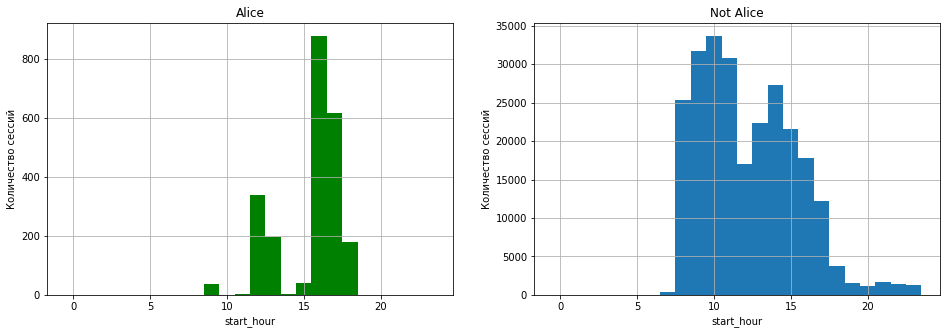

In [12]:
plot_feature_hist('start_hour', train_features, y, bins=np.linspace(0-0.5, 23+0.5, 24+1))

*Распределения существенно отличаются. Активность Alice сконцентрирована в трех временных промежутках: 9 часов, 12-13 часов и 15-18 часов, при этом активность растет в течение дня. Активность не Alice понижается в течение дня, начинается раньше (в 8 часов) и заканчивается позже (в 23 часа), имеет лишь один спад в районе 12 часов и сильно понижается после 17 часов.*

Распределение времени суток:

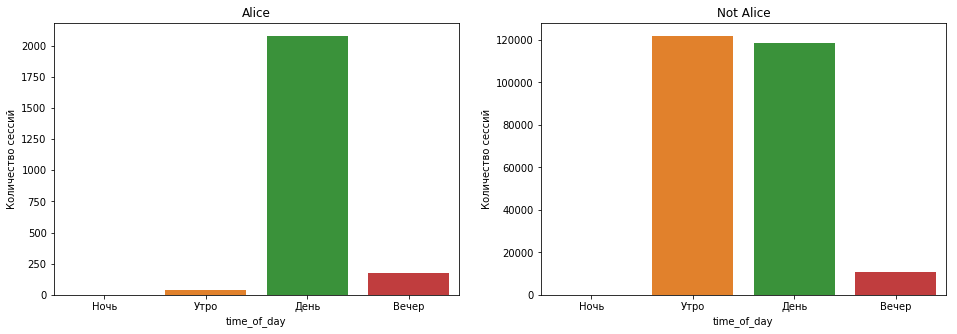

In [13]:
ticks = {0: u'Ночь', 1: u'Утро', 2: u'День', 3: u'Вечер'}
plot_feature_count('time_of_day', train_features, y, ticks=ticks)

*Как и было отмечено ранее, Alice активна в основном днем (12:00-17:00), в то время, как не Alice имеет активность утром, сопоставимую с активностью днем.*

Распределение дня недели:

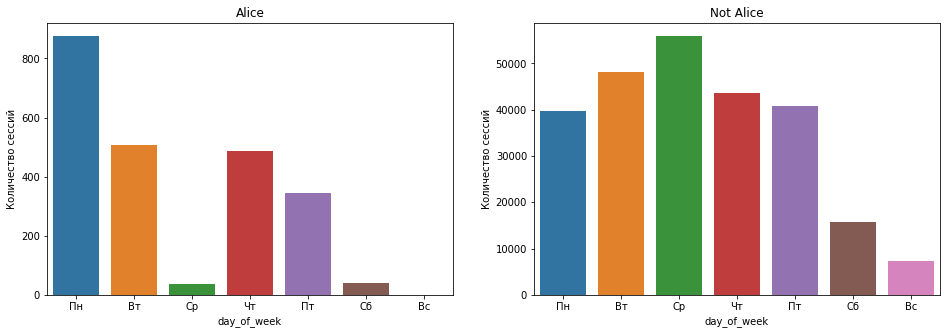

In [14]:
ticks = {0: u'Пн', 1: u'Вт', 2: u'Ср', 3: u'Чт', 4: u'Пт', 5: u'Сб', 6: u'Вс'}
plot_feature_count('day_of_week', train_features, y, ticks=ticks)

*Активность Alice максимальна в понедельник, и при этом очень мала в среду и в выходные. Активность не Alice относительно равномерна в будни и на выходные имеет лишь некоторый спад.*

Распределение индикатора выходных:

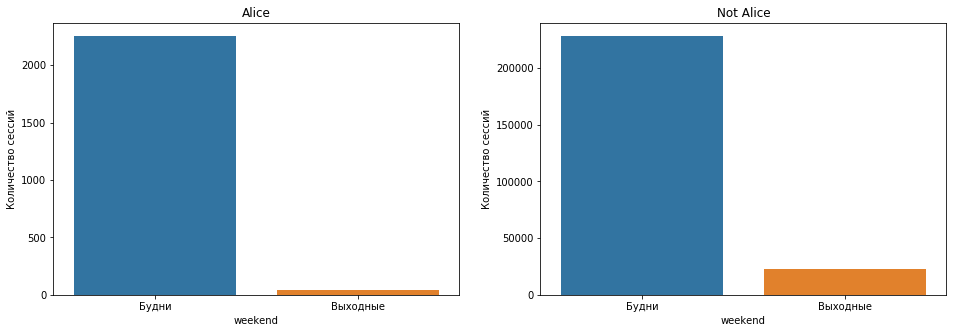

In [15]:
ticks = {0: u'Будни', 1: u'Выходные'}
plot_feature_count('weekend', train_features, y, ticks=ticks)

*Как и было отмечено ранее, Alice практически неактивна в выходные, в то время как не Alice в выходные имеет малую, но все же заметную активность.*

### Обучение модели

Отделим 30% обучающей выборки для валидации модели:

In [16]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

Зададим тип кросс-валидации: 3-кратная, стратифицированная, с перемешиванием.

In [17]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Вспомогательная функция для отрисовки кривых валидации:

In [18]:
def plot_validation_curves(param_values, grid_cv_results_, scale='linear', figsize=(15, 10)):
    plt.figure(figsize=figsize)
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    print('CV std: {}'.format(max(zip(valid_mu, valid_std), key=lambda x: x[0])[1]))
    if scale == 'linear':
        train_line = plt.plot(param_values, train_mu, '-', label='Training score', color='g')
        valid_line = plt.plot(param_values, valid_mu, '-', label='Cross-validation score', color='r')
    if scale == 'log':
        train_line = plt.semilogx(param_values, train_mu, '-', label='Training score', color='g')
        valid_line = plt.semilogx(param_values, valid_mu, '-', label='Cross-validation score', color='r')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.xlabel('Parameter')
    plt.ylabel('Score')
    plt.legend()

Обучать будем модель логистической регресии. Так как данных довольно много, будем использовать стохастический градиентный спуск (`SDGClassifier`).

Параметр `alpha` будем подбирать с помощью `GridSearchCV`. Сначала будем перебирать его на промежутке от 1e-6 до 1e3:

Best alpha = 1e-05
Best CV score (roc auc) = 0.9783272278309102
CV std: 0.001691420797
Test score (roc auc) = 0.9783865242774644
Wall time: 7.11 s


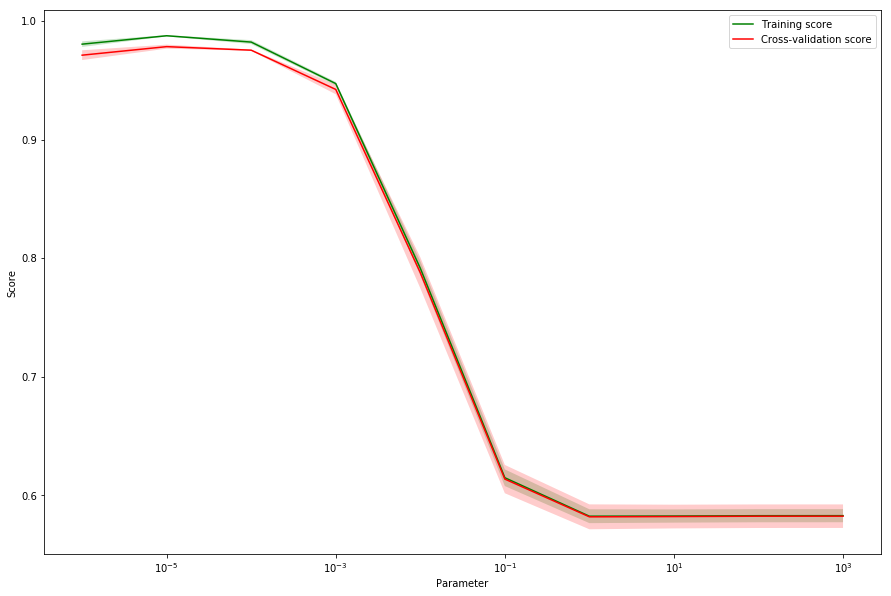

In [19]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, 3, 10)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best alpha =', sgd_logit_best_alpha)
print('Best CV score (roc auc) =', sgd_logit_best_score)

plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log', figsize=(15, 10))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

Теперь, когда видно, где параметр `alpha` достигает максимума, переберем его вновь в более подходящем промежутке:

Best alpha = 2.8072162039411757e-05
Best CV score (roc auc) = 0.9802166312281319
CV std: 0.000748479884719
Test score (roc auc) = 0.9792525947221293
Wall time: 18.7 s


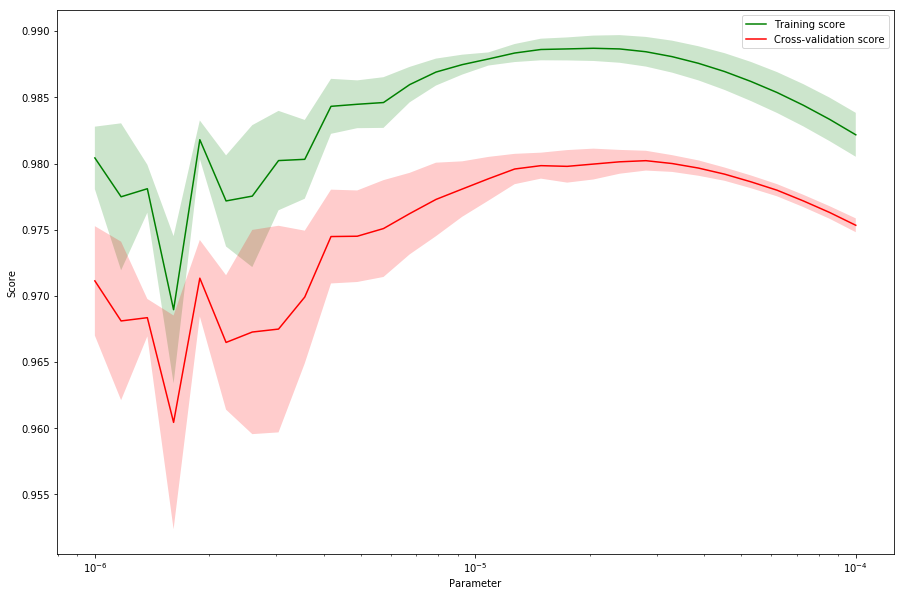

In [20]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, -4, 30)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best alpha =', sgd_logit_best_alpha)
print('Best CV score (roc auc) =', sgd_logit_best_score)

plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log', figsize=(15, 10))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

Улучшилось и качество на кросс-валидации, и стандартное отклонение, и качество на тесте. Новое `alpha` однозначно лучше.

Построим кривые обучения:

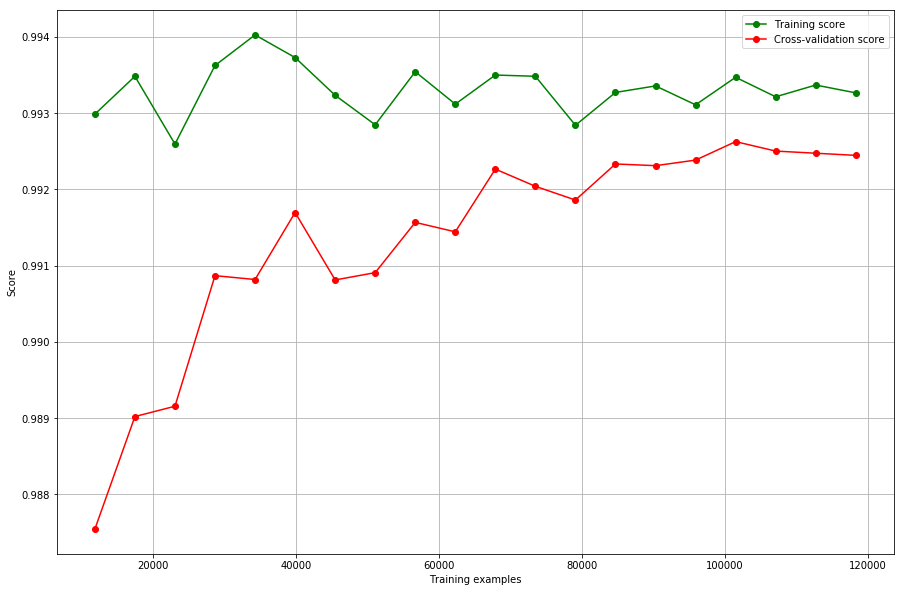

Wall time: 6.25 s


In [21]:
%%time
train_sizes_abs, train_scores, test_scores = learning_curve(sgd_logit_grid_searcher.best_estimator_, X_train, y_train, 
                                                            cv=skf, train_sizes=np.linspace(0.1, 1.0, 20))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(15, 10))
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='g', label='Training score')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color='r', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

Качество на обучении и кросс-валидации приближаются друг к другу, но скорость сближения замедляется с ростом размера обучающей выборки, остается разрыв. Нет ни выраженного недообучения, ни выраженного переобучения. Стоит усложнить модель - построить новые признаки, чтобы выявить возможные закономерности, которые отличают тестовые данные от кросс-валидационных, и тем самым уменьшить разрыв. Но и увеличение количества данных не повредит - качество на кросс-валидации не достигло плато и продолжает улучшаться.

### Отправка результата на Kaggle

Построим предсказания на тестовой выборке (без целевого признака) и узнаем результат на публичном лидерборде в соревновании на Kaggle:

In [22]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [23]:
logit_test_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'SGDClassifier_GridSearch_4feat.csv'))

Результат на публичном лидерборде - 0.94257.

### Оценка модели

Обученная нами модель демонстрирует значение метрики ROC-AUC = 0.97925 на отложенной выборке. Чтобы оценить, насколько это хорошо, рассмотрим значение метрики ROC-AUC на наивных классификаторах, не использующих информацию из выборки:
* Константных - относящих все сессии к классу 0 или к классу 1
* Случайных - произвольно относящих каждую сессию к классу 1 с некоторой вероятностью p. Для примера рассмотрим 4 случая: p=0.5, p=0.25, p=0.75 и стратифицированный, т.е. с вероятностью p, равной доле класса 1 среди меток класса на обучающей выборке.

In [24]:
np.random.seed(17)
print(u'ROC-AUC на константном классификаторе 0:', roc_auc_score(y, np.zeros(len(y)) ))
print(u'ROC-AUC на константном классификаторе 1:', roc_auc_score(y, np.ones(len(y)) ))
print(u'ROC-AUC на случайном классификаторе с p=0.5:', roc_auc_score(y, np.random.binomial(1, 0.5, size=len(y)) ))
print(u'ROC-AUC на случайном классификаторе с p=0.25:', roc_auc_score(y, np.random.binomial(1, 0.25, size=len(y)) ))
print(u'ROC-AUC на случайном классификаторе с p=0.75:', roc_auc_score(y, np.random.binomial(1, 0.75, size=len(y)) ))
print(u'ROC-AUC на стратифицированном случайном классификаторе:', 
      roc_auc_score(y, np.random.binomial(1, sum(y)/len(y), size=len(y)) ))

ROC-AUC на константном классификаторе 0: 0.5
ROC-AUC на константном классификаторе 1: 0.5
ROC-AUC на случайном классификаторе с p=0.5: 0.5045777586398658
ROC-AUC на случайном классификаторе с p=0.25: 0.5062656764213371
ROC-AUC на случайном классификаторе с p=0.75: 0.49800514302776155
ROC-AUC на стратифицированном случайном классификаторе: 0.49942487214768383


Как можно видеть, все наивные классификаторы достигают значение метрики ROC-AUC около 0.5. Таким образом, построенная модель значительно лучше наивных классификаторов.

### Выводы

Построенная модель может применяться в сфере информационной безопасности. С помощью модели можно определить, был ли совершен взлом аккаунта веб-сервиса, еще до того, как об этом заявит владелец аккаунта или злоумышленник совершит вредоносное действие. Таким же образом можно отслеживать нелегальную передачу аккаунта, например, продажу.

Существующие методы контроля доступа лишь затрудняют проникновение злоумышленника, но не решают проблему взлома полностью. Узким местом остается использование пароля, который может быть потерян, украден, перехвачен или подобран. Использование модели может помочь там, где эти методы бессильны - в ситуации, когда злоумышленник уже обладает паролем пользователя.

### Дальнейшие предложения

Для улучшения качества модели можно попробовать придумать и построить новые признаки, лучше отражающие информацию о сессии. 

Например:
* Учесть последовательность посещения сайтов. Пользователь, как правило, переходит по ссылкам, и для того, чтобы попасть с сайта 1 на сайт 2, нужно, чтобы на сайте 1 была соответствующая ссылка, что ограничивает возможности для сайта 2. Можно считать не только количества встречаемости сайта в сессии, но и встречаемости биграмм, триграмм, и т.д., либо иначе кодировать сессии, чтобы учесть порядок посещения.
* Вместо количеств встречаемости сайта в сессии использовать меру tf-idf из анализа текстов. Так можно будет лучше отличать характерные для Alice сайты от просто популярных, например, google.
* Объединить сайты в зависимости от доменного имени. Например, если не различать youtube.com и youtube.ru, то, возможно, удастся уловить более важные зависимости.
* Попробовать многие другие признаки - длина сессии в секундах, количество уникальных сайтов, доля популярных сайтов (скажем, топ-30) в сессии, и т.д.